In [1]:
import numpy as np
import torch.optim as optim
from torch.optim import lr_scheduler
import torch
import torch.nn as nn
from torchvision import datasets
from torchvision import transforms
from torch.utils.data.sampler import SubsetRandomSampler
import torchvision.models as models
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import librosa
import librosa.display
import os
import shutil
import json
from ast import literal_eval
from audiomentations import AddGaussianNoise, AirAbsorption, ApplyImpulseResponse, BandPassFilter, GainTransition, RepeatPart, TimeStretch, TanhDistortion
from sklearn.model_selection import train_test_split
import time
import copy

C:\Users\wying\AppData\Roaming\Python\Python39\site-packages\torchvision\io\image.py:13: UserWarning: Failed to load image Python extension: '[WinError 127] The specified procedure could not be found'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Data Proprocessing

In [3]:
def get_spectrogram(signal, sr=22050):
  spectrogram = librosa.feature.melspectrogram(y=signal, sr=sr)
  return librosa.amplitude_to_db(spectrogram)

def get_mfcc(signal, n_mfcc=13):
    return librosa.feature.mfcc(y=signal, n_mfcc=n_mfcc)

In [4]:
from preprocess import create_signal_dataframe

In [5]:
df = create_signal_dataframe()
signal = np.vstack(df["signal"])
label = np.array(df["label"])
x_train, x_test, y_train, y_test = train_test_split(signal, label, test_size=0.2)
print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)

spectrogram_train = get_spectrogram(x_train)
print(spectrogram_train.shape)

mfcc_train = get_mfcc(x_train)
print(mfcc_train.shape)

spectrogram_test = get_spectrogram(x_test)
print(spectrogram_test.shape)

mfcc_test = get_mfcc(x_test)
print(mfcc_test.shape)

(700, 44100) (700,) (175, 44100) (175,)
(700, 128, 87)
(700, 13, 87)
(175, 128, 87)
(175, 13, 87)


In [6]:
def create_loader(spectrogram_train, mfcc_train, y_train, batch_ize=35):
  train_data_spectrogram = []
  train_data_mfcc = []
  for i in range(spectrogram_train.shape[0]):
      train_data_spectrogram.append((spectrogram_train[i], y_train[i]))
      train_data_mfcc.append((mfcc_train[i], y_train[i]))
  train_loader_spectrogram = torch.utils.data.DataLoader(train_data_spectrogram, batch_size=batch_ize)
  train_loader_mfcc = torch.utils.data.DataLoader(train_data_mfcc, batch_size=batch_ize)
  return train_loader_spectrogram, train_loader_mfcc

In [7]:
train_loader_spectrogram, train_loader_mfcc = create_loader(spectrogram_train, mfcc_train, y_train, batch_ize=35)

In [8]:
test_loader_spectrogram, test_loader_mfcc = create_loader(spectrogram_test, mfcc_test, y_test, batch_ize=5)

RNN for MFCC data

In [9]:
import torch
import torch.nn as nn

class ImageRNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(ImageRNN, self).__init__()

        self.hidden_size = hidden_size
        self.rnn = nn.RNN(input_size, hidden_size, batch_first=True)
        self.act = nn.ReLU()
        self.dropout = nn.Dropout(0.2)
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        # Initialize hidden state with zeros
        batch_size = x.size(0)
        h0 = torch.zeros(1, batch_size, self.hidden_size).to(x.device)
        
        # Forward propagate RNN
        out, _ = self.rnn(x, h0)
        # out = nn.functional.max
        out = self.act(out)
        out = self.dropout(out)
        # Decode the hidden state of the last time step
        out = self.fc(out[:, -1, :])
        return out

In [10]:
class ImageRNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers=2, num_classes=10):
        super(ImageRNN, self).__init__()

        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.act = nn.ReLU()
        self.dropout = nn.Dropout(0.5)
        self.fc = nn.Sequential(
            nn.Linear(hidden_size, 256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, num_classes)
        )
        self.hidden_size = hidden_size
        self.num_layers = num_layers

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)

        out, _ = self.lstm(x, (h0, c0))
        out = torch.max(out, dim=1).values
        
        out = self.act(out)
        out = self.dropout(out)
        out = self.fc(out)
        return out

In [11]:
input_size = 87
hidden_size = 1024
num_classes = 10
learning_rate = 0.0001
num_epochs = 100

model_mfcc = ImageRNN(input_size, hidden_size, num_layers=2).to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()

In [12]:
def validation(model, test_loader):
  with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
      images = images.to(device)
      labels = labels.to(device)
      outputs = model(images)
      _, predicted = torch.max(outputs.data, 1)
      total += labels.size(0)
      correct += (predicted == labels).sum().item()
  return 100 * correct / total

In [13]:
def train(model, train_loader_mfcc, test_loader_mfcc, num_epochs, criterion, mfcc_model_save_path, learning_rate):
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=5e-4)
    val_accu_lst = []
    train_per_weight_update = []
    for epoch in range(num_epochs):
        correct = 0
        total = 0
        for i, (images, labels) in enumerate(train_loader_mfcc):
            # Move tensors to the configured device
            images = images.to(device)
            labels = labels.to(device)

            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)
            train_per_weight_update.append(loss)

            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        val_acc = validation(model, test_loader_mfcc)
        train_acc = validation(model, train_loader_mfcc)

        print(
            "Epoch: [{}/{}], Validation Accuracy: {:.4f}".format(
                epoch + 1, num_epochs, val_acc
            )
        )
        print(f"train accuracy: {train_acc}")
        val_accu_lst.append(val_acc)
        #torch.save(model.state_dict(), mfcc_model_save_path)
    return train_per_weight_update, val_accu_lst

In [14]:
spec_model_save_path = "./models/rnn_spectrogram.pth"
mfcc_model_save_path = "./models/rnn_mfcc.pth"

In [15]:
train_per_weight_update, val_accu_lst = train(
    model_mfcc,
    train_loader_mfcc,
    test_loader_mfcc,
    num_epochs,
    criterion,
    mfcc_model_save_path,
    learning_rate=learning_rate
)

Epoch: [1/100], Validation Accuracy: 24.5714
train accuracy: 34.142857142857146
Epoch: [2/100], Validation Accuracy: 37.7143
train accuracy: 36.857142857142854
Epoch: [3/100], Validation Accuracy: 41.7143
train accuracy: 46.0
Epoch: [4/100], Validation Accuracy: 50.2857
train accuracy: 53.42857142857143
Epoch: [5/100], Validation Accuracy: 54.8571
train accuracy: 60.42857142857143
Epoch: [6/100], Validation Accuracy: 54.8571
train accuracy: 64.57142857142857
Epoch: [7/100], Validation Accuracy: 61.7143
train accuracy: 67.57142857142857
Epoch: [8/100], Validation Accuracy: 62.8571
train accuracy: 70.28571428571429
Epoch: [9/100], Validation Accuracy: 64.0000
train accuracy: 75.0
Epoch: [10/100], Validation Accuracy: 65.7143
train accuracy: 78.42857142857143
Epoch: [11/100], Validation Accuracy: 66.2857
train accuracy: 79.85714285714286
Epoch: [12/100], Validation Accuracy: 66.8571
train accuracy: 82.57142857142857
Epoch: [13/100], Validation Accuracy: 66.8571
train accuracy: 81.71428571

Text(0.5, 1.0, 'validation accuracy on mfcc')

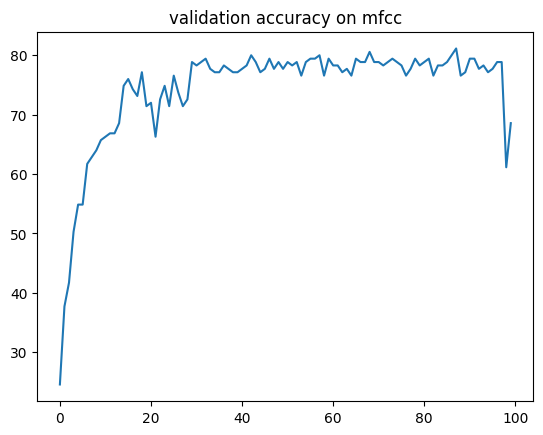

In [16]:
plt.plot(val_accu_lst)
plt.title("validation accuracy on mfcc")

Text(0.5, 1.0, 'train loss on mfcc')

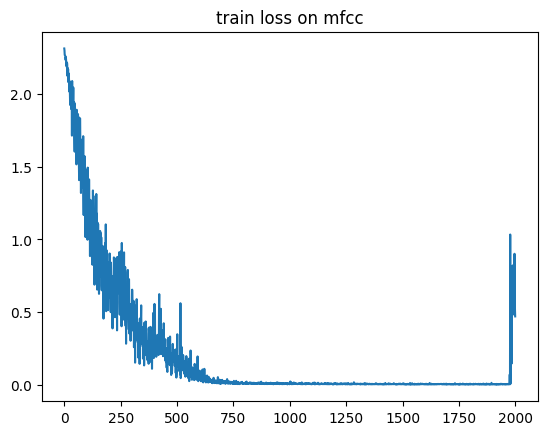

In [17]:
plt.plot([loss.item() for loss in train_per_weight_update])
plt.title("train loss on mfcc")

RNN for Spectrogram

In [18]:
input_size = 87
hidden_size = 512
num_classes = 10
learning_rate = 0.0001
num_epochs = 30

model_spec = ImageRNN(input_size, hidden_size).to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()


In [19]:
train_per_weight_update_spec, val_accu_lst_spec = train(
    model_spec,
    train_loader_spectrogram,
    test_loader_spectrogram,
    num_epochs,
    criterion,
    spec_model_save_path,
    learning_rate=learning_rate
)

Epoch: [1/30], Validation Accuracy: 19.4286
train accuracy: 28.571428571428573
Epoch: [2/30], Validation Accuracy: 29.7143
train accuracy: 29.428571428571427
Epoch: [3/30], Validation Accuracy: 28.5714
train accuracy: 32.42857142857143
Epoch: [4/30], Validation Accuracy: 29.1429
train accuracy: 43.857142857142854
Epoch: [5/30], Validation Accuracy: 29.1429
train accuracy: 44.285714285714285
Epoch: [6/30], Validation Accuracy: 28.5714
train accuracy: 50.0
Epoch: [7/30], Validation Accuracy: 29.1429
train accuracy: 53.714285714285715
Epoch: [8/30], Validation Accuracy: 31.4286
train accuracy: 54.142857142857146
Epoch: [9/30], Validation Accuracy: 30.2857
train accuracy: 60.285714285714285
Epoch: [10/30], Validation Accuracy: 34.2857
train accuracy: 60.42857142857143
Epoch: [11/30], Validation Accuracy: 32.5714
train accuracy: 60.285714285714285
Epoch: [12/30], Validation Accuracy: 33.7143
train accuracy: 58.42857142857143
Epoch: [13/30], Validation Accuracy: 32.0000
train accuracy: 60.85

Text(0.5, 1.0, 'Spectrogram Training loss')

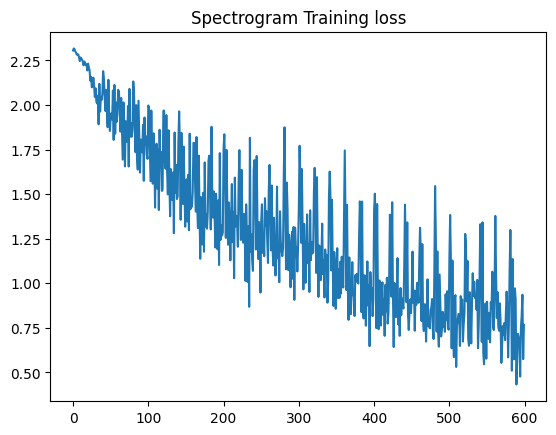

In [22]:
plt.plot([loss.item() for loss in train_per_weight_update_spec])
plt.title("Spectrogram Training loss")

Text(0.5, 1.0, 'Spectrogram Validation Accuracy')

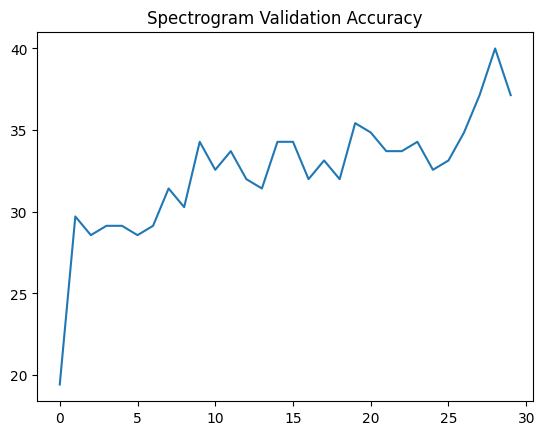

In [23]:
plt.plot(val_accu_lst_spec)
plt.title("Spectrogram Validation Accuracy")